### Class K_Nearest_PMedian

| Class: K_Nearest_PMedian                |
|-----------------------------------------|
| - aij: np.array                         |
| - ai_sum: Union[int, float]             |
| - name: str                             |
| - problem: pulp.LpProblem               |
|-----------------------------------------|
| + __init__(name, problem, aij, ai_sum)          |
| + __add_obj(max_distance, range_clients, range_facility) |
| + _create_sparse_matrix(clients, facilities, k_list, metric) |
| + _create_k_list(k_list)                 |
| + _from_sparse_matrix(sparse_distance_matrix, weights, facility_capacities, name) |
| + from_geodataframe(k_list, gdf_demand, gdf_fac, demand_col, facility_col, weights_cols, facility_capacity_col, distance_metric, name) |
| + from_cost_matrix(cls, *args, **kwargs) |
| + facility_client_array()                |
| + solve(solver, results)                |

In [1]:
import warnings
from typing import Union

import numpy as np
import pulp
from geopandas import GeoDataFrame
from scipy.spatial.distance import cdist

from spopt.locate.p_median import PMedian
from spopt.locate.base import (
    BaseOutputMixin,
    FacilityModelBuilder,
    LocateSolver,
    MeanDistanceMixin,
    SpecificationError,
)

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
<ipython-input-1-34568d5adc21>:6: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling 

In [1]:
from scipy.sparse import find
from pointpats.geometry import build_best_tree
from scipy.sparse import csr_matrix

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
class KNearestPMedian(PMedian):
    r"""
    Implement the P-Median Model with Near-Far Cost Allocation and solve it. The model is adapted from :cite:`richard_2018`, 
    can be formulated as:


    .. math::

       \begin{array}{lllll}
       \displaystyle \textbf{Minimize}      & \displaystyle \sum_{i \in I}\sum_{k \in k_{i}}{a_i d_{ik} X_{ik}} + \sum_{i \in I}{g_i (d_{i{k_i}} + 1)}  &&                                          & (1)                                                                               \\
       \displaystyle \textbf{Subject To}    & \\sum_{k \in k_{i}}{X_{ik} + g_i = 1}                                                                     && \forall i \in I                          & (2)                                                                               \\
                                            & \sum_{j \in J}{Y_j} = p                                                                                   &&                                          & (3)                                                                               \\
                                            & \sum_{i \in I}{a_i X_{ik}} \leq {Y_{k} c_{k}}                                                             &&  \forall k \in k_{i}                     & (4)                                                                               \\  
                                            & X_{ij} \leq Y_{j}                                                                                         && \forall i \in I \quad \forall j \in J    & (5)                                                                               \\
                                            & X_{ij} \in \{0, 1\}                                                                                       && \forall i \in I \quad \forall j \in J    & (6)                                                                               \\
                                            & Y_j \in \{0, 1\}                                                                                          && \forall j \in J                          & (7)                                                                               \\
                                            &                                                                                                           &&                                          &                                                                                   \\
       \displaystyle \textbf{Where}         && i                                                                                                        & =                                         & \textrm{index of demand points/areas/objects in set } I                           \\
                                            && j                                                                                                        & =                                         & \textrm{index of potential facility sites in set } J                              \\
                                            && p                                                                                                        & =                                         & \textrm{the number of facilities to be sited}                                     \\
                                            && a_i                                                                                                      & =                                         & \textrm{service load or population demand at client location } i                  \\
                                            && k_{i}                                                                                                    & =                                         & \textrm{the } k {nearest facilities of client location } i                        \\
                                            && c_{j}                                                                                                    & =                                         & \textrm{the capacity of facility} j                                               \\   
                                            && d_{ij}                                                                                                   & =                                         & \textrm{shortest distance or travel time between locations } i \textrm{ and } j   \\
                                            && X_{ij}                                                                                                   & =                                         & \begin{cases}
                                                                                                                                                                                                       1, \textrm{if client location } i \textrm{ is served by facility } j             \\
                                                                                                                                                                                                       0, \textrm{otherwise}                                                            \\
                                                                                                                                                                                                      \end{cases}                                                                       \\
                                            && Y_j                                                                                                      & =                                         & \begin{cases}
                                                                                                                                                                                                       1, \textrm{if a facility is sited at location } j                                \\
                                                                                                                                                                                                       0, \textrm{otherwise}                                                            \\
                                                                                                                                                                                                      \end{cases}                                                                       \\ 
                                            && g_i                                                                                                      & =                                         & \begin{cases}
                                                                                                                                                                                                       1, \textrm{if the client } i {need to be served by non-k-nearest facilities}     \\
                                                                                                                                                                                                       0, \textrm{otherwise}                                                            \\
                                                                                                                                                                                                      \end{cases}                                                                       \\
       \end{array}

    Parameters
    ----------

    name : str
        The problem name.
    ai_sum : Union[int, float]
        The sum of weights representing the service loads of the clients.
    clients : np.array
        An array of coordinates of clients.
    facilities : np.array
        An array of coordinates of facilities.
    weights : np.array
        An array of weights representing the service loads of the clients.
    p_facilities: int
        The number of facilities to be located.
    capacities : np.array or None
        An array of facility capacities. None if capacity constraints are not considered.
    k_list : np.array
        An array of k values representing the number of nearest facilities for each client.
    distance_metric : str
        The distance metric used for computing distances between clients and facilities.
    
    Attributes
    ----------
    
    sparse_matrix : Compressed Sparse Row matrix
        A cost matrix in the form of a compressed sparse row matrix between origins and destinations.
    aij : Compressed Sparse Row matrix
        A weighted cost matrix in the form of a compressed sparse row matrix between origins and destinations.
    problem : pulp.LpProblem
        A ``pulp`` instance of an optimization model that contains
        constraints, variables, and an objective function.
    fac2cli : numpy.array
        A 2D array storing facility to client relationships where each
        row represents a facility and contains an array of client indices
        with which it is associated. An empty client array indicates
        the facility is associated with no clients.
    cli2fac : numpy.array
        The inverse of ``fac2cli`` where client to facility relationships
        are shown.
    

    """  # noqa

    def __init__(
        self,
        weights_sum: Union[int, float],
        clients: np.array, 
        facilities: np.array,
        weights: np.array,
        k_list: np.array,
        p_facilities: int,
        capacities: np.array = None,
        distance_metric: str = "euclidean",
        name='k-nearest p median'
    ):
        self.ai_sum = weights_sum
        self.clients = clients
        self.facilities = facilities
        self.weights = weights
        self.k_list = k_list
        self.p_facilities = p_facilities
        self.capacities = capacities
        self.distance_metric = distance_metric
        self.name = name

    def __add_obj(
        self, max_distance: np.array, range_clients: range, range_facility: range
    ) -> None:
        """
        Add the objective function to the model.
        
        Parameters
        ----------

        max_distance : np.array
            An array of distances between each client and their kth nearest facility. For example, if k = 2, this array
            will only store the distance between each client and their 2nd nearest facility.
        range_clients : range
            The range of demand points.
        range_facility : range
            The range of facility point.

        Returns
        -------

        None

        """
        cli_assgn_vars = getattr(self, "cli_assgn_vars")
        placeholder_vars = getattr(self, "placeholder_vars")

        self.problem += (
            pulp.lpSum(
                pulp.lpSum(
                    self.aij[i, j] * cli_assgn_vars.get((i, j), 0)
                    for j in range_facility
                )
                + (placeholder_vars[i] * (max_distance[i] + 1))
                for i in range_clients
            ),
            "objective function",
        )

    @classmethod
    def from_cost_matrix(cls, *args, **kwargs):
        """
        Warning: This method is not supported in the KNearestPMedian subclass.
        """
        raise NotImplementedError(
            "from_cost_matrix method is not supported in KNearestPMedian class."
        )

    def _create_sparse_matrix(self) -> None:
        """
        Create a sparse matrix representing the distance between clients and their k nearest facilities.

        This method uses a suitable tree data structure (built with the `build_best_tree` function)
        to efficiently find the k nearest facilities for each client based on the specified distance metric.
        The resulting distances are stored in a sparse matrix format to conserve memory for large datasets.

        Returns
        -------

        None
        """

        row_shape = len(self.clients)
        column_shape = len(self.facilities)

        # check the k value with the total number of facilities
        for k in self.k_list:
            if k > column_shape:
                raise ValueError(
                    f"The value of k should be no more than the number of total facilities ({column_shape})."
                )

        # Initialize empty lists to store the data for the sparse matrix
        data = []
        row_index = []
        col_index = []

        # create the suitable Tree
        tree = build_best_tree(self.facilities, self.distance_metric)

        for i, k in enumerate(self.k_list):
            # Query the Tree to find the k nearest facilities for each client
            distances, k_nearest_facilities_indices = tree.query([self.clients[i]], k=k)

            # extract the contents of the inner array
            distances = distances[0].tolist()
            k_nearest_facilities_indices = k_nearest_facilities_indices[0].tolist()

            # Append the data for the sparse matrix
            data.extend(distances)
            row_index.extend([i] * k)
            col_index.extend(k_nearest_facilities_indices)
        # Create the sparse matrix using csr_matrix
        self.sparse_matrix = csr_matrix(
            (data, (row_index, col_index)), shape=(row_shape, column_shape)
        )

    def _create_k_list(self) -> None:
        """
        Increase the k value of clients with any g_i > 0 and create a new k list.
        This method is used to adjust the k values for clients based on their placeholder variable g_i.
        For clients with g_i greater than 0, the corresponding k value is increased by 1 in the new k list.

        Returns
        -------

        None
        """
        new_k_list = self.k_list.copy()
        placeholder_vars = getattr(self, "placeholder_vars")
        for i in range(len(placeholder_vars)):
            if placeholder_vars[i].value() > 0:
                new_k_list[i] = new_k_list[i] + 1
        self.k_list = new_k_list

    def _from_sparse_matrix(self) -> None:
        """
        Create the k nearest p-median problem from the sparse distance matrix.

        Returns
        -------

        None
        """
        n_cli = self.sparse_matrix.shape[0]
        r_cli = range(n_cli)
        r_fac = range(self.sparse_matrix.shape[1])

        self.weights = np.reshape(self.weights, (n_cli, 1))
        self.aij = self.sparse_matrix.multiply(self.weights).tocsr()

        # create the model/problem
        self.problem = pulp.LpProblem(self.name, pulp.LpMinimize)

        # add all the 1)decision variable, 2)objective function, and 3)constraints

        # Facility integer decision variable
        FacilityModelBuilder.add_facility_integer_variable(
            self, r_fac, "y[{i}]"
        )
        fac_vars = getattr(self, "fac_vars")
        # Placeholder decision variable
        placeholder_vars = pulp.LpVariable.dicts(
            "g", (i for i in r_cli), 0, 1, pulp.LpBinary
        )
        setattr(self, "placeholder_vars", placeholder_vars)

        # Client assignment integer decision variables
        row_indices, col_indices, values = find(self.aij)
        cli_assgn_vars = pulp.LpVariable.dicts(
            "z", [(i, j) for i, j in zip(row_indices, col_indices)], 0, 1, pulp.LpBinary
        )
        setattr(self, "cli_assgn_vars", cli_assgn_vars)

        # Add the objective function
        max_distance = self.aij.max(axis=1).toarray().flatten()
        self.__add_obj(max_distance, r_cli, r_fac)

        # Create the capacity constraints
        if self.capacities is not None:
            sorted_capacities = np.sort(self.capacities)
            highest_possible_capacity = sorted_capacities[-self.p_facilities:].sum()
            if highest_possible_capacity < self.ai_sum:
                raise SpecificationError(
                    "Problem is infeasible. The highest possible capacity "
                    f"{highest_possible_capacity}, coming from the {self.p_facilities} "
                    "sites with the highest capacity, is smaller than "
                    f"the total demand {self.ai_sum}."
                )
            for j in col_indices:
                self.problem += (
                    pulp.lpSum(
                        self.weights[i] * cli_assgn_vars.get((i, j), 0) for i in r_cli
                    )
                    <= fac_vars[j] * self.capacities[j]
                )

        # Create assignment constraints.
        for i in r_cli:
            self.problem += (
                pulp.lpSum(cli_assgn_vars.get((i, j), 0) for j in set(col_indices))
                + placeholder_vars[i]
                == 1
            )
        # Create the facility constraint.
        FacilityModelBuilder.add_facility_constraint(self, self.p_facilities)


    @classmethod
    def from_geodataframe(
        cls,
        k_list: np.array,
        gdf_demand: GeoDataFrame,
        gdf_fac: GeoDataFrame,
        demand_col: str,
        facility_col: str,
        weights_cols: str,
        p_facilities: int,
        facility_capacity_col: str = None,
        distance_metric: str = "euclidean",
        name: str = "k-nearest-p-median",
    ):
        """
        Create the object of KNearestPMedian class using input data.

        Parameters
        ----------
        k_list : np.array
            An array of integers representing the list of k values for each client.
        gdf_demand : GeoDataFrame
            A GeoDataFrame containing demand points (clients) with their associated attributes.
        gdf_fac : GeoDataFrame
            A GeoDataFrame containing facility points with their associated attributes.
        demand_col : str
            The column name in gdf_demand representing the coordinate information of each client.
        facility_col : str
            The column name in gdf_fac representing the coordinate information of each facility.
        weights_cols : str
            The column name in gdf_demand representing the weights or service load for each client.
        p_facilities: int
           The number of facilities to be located.
        facility_capacity_col : str, optional
            The column name in gdf_fac representing the capacity of each facility, by default None.
        distance_metric : str, optional
            The distance metric to be used in calculating distances between clients and facilities,
            by default "euclidean".
        name : str, optional
            The name of the problem, by default "k-nearest-p-median".

        Returns
        -------
        
        spopt.locate.p_median.KNearestPMedian

        Exceptions
        --------
        - The GeoDataFrames must have a valid CRS to perform distance calculations accurately. And the CRS of gdf_demand
            and gdf_fac must be the same one.

        Examples
        --------
        >>> from spopt.locate import KNearestPMedian
        >>> import geopandas

        Create the input data and attributes.

        >>> k_list = np.array([1, 1])
        >>> demand_data = {'ID': [1, 2], 'geometry': [Point(0.5, 1), Point(1.5, 1)],'demand': [1, 1]}
        >>> facility_data = {'ID': [101, 102], 'geometry': [Point(1,1), Point(0, 2), Point(2, 0)],'capacity': [1, 1, 1]}
        >>> gdf_demand = geopandas.GeoDataFrame(demand_data, crs='EPSG:4326')
        >>> gdf_fac = geopandas.GeoDataFrame(facility_data, crs='EPSG:4326')

        Create and solve a ``KNearestPMedian`` instance from the geodataframe.
        
        >>> k_nearest_pmedian = KNearestPMedian.from_geodataframe(k_list, gdf_demand, gdf_fac,
        ...                                                         'geometry','geometry',
        ...                                                         demand_col='ID',
        ...                                                         facility_col='ID',
        ...                                                         weights_cols='demand',
        ...                                                         2,
        ...                                                         facility_capacity_col='capacity')
        >>> k_nearest_pmedian = k_nearest_pmedian.solve(pulp.PULP_CBC_CMD(msg=False))
        
        Get the facility-client associations.
        
        >>> for fac, cli in enumerate(k_nearest_pmedian.fac2cli):
        ...     print(f"facility {fac} serving {len(cli)} clients")
        facility 0 serving 1 clients
        facility 1 serving 1 clients
        facility 2 serving 0 clients

        Get the total and average weighted travel cost.

        >>> round(k_nearest_pmedian.problem.objective.value(), 3)
        1.618
        >>> round(k_nearest_pmedian.mean_dist, 3)
        0.809

        Get the k list for the last iteration.
        >>> print(k_nearest_pmedian.k_list)
        [2, 1]

        """

        # check the crs of two geodataframes
        if gdf_demand.crs is None:
            raise ValueError("GeoDataFrame gdf_demand does not have a valid CRS.")
        if gdf_fac.crs is None:
            raise ValueError("GeoDataFrame gdf_facility does not have a valid CRS.")
        if gdf_demand.crs != gdf_fac.crs:
            raise ValueError(
                "Geodataframes crs are different: "
                f"gdf_demand-{gdf_demand.crs}, gdf_fac-{gdf_fac.crs}"
            )

        # create the array of coordinate of clients and facilities
        dem = gdf_demand[demand_col]
        fac = gdf_fac[facility_col]
        dem_data = np.array([dem.x.to_numpy(), dem.y.to_numpy()]).T
        fac_data = np.array([fac.x.to_numpy(), fac.y.to_numpy()]).T

        # set the demand and capacity
        service_load = gdf_demand[weights_cols].to_numpy()
        weights_sum = service_load.sum()
        facility_capacities = None
        if facility_capacity_col is not None:
            facility_capacities = gdf_fac[facility_capacity_col].to_numpy()

        return KNearestPMedian(
            weights_sum, 
            dem_data, 
            fac_data, 
            service_load,
            k_list,
            p_facilities,
            facility_capacities,
            distance_metric,
            name)
        
    def facility_client_array(self) -> None:
        """

        Create a 2D array storing **facility to client relationships** where each
        row represents a facility and contains an array of client indices
        with which it is associated. An empty client array indicates
        the facility is associated with no clients.

        Returns
        -------

        None
        """
        fac_vars = getattr(self, "fac_vars")
        cli_vars = getattr(self, "cli_assgn_vars")
        len_fac_vars = len(fac_vars)

        self.fac2cli = []

        for j in range(len_fac_vars):
            array_cli = []
            if fac_vars[j].value() > 0:
                for i in range(len(cli_vars)):
                    if (i, j) in cli_vars and cli_vars[i, j].value() > 0:
                        array_cli.append(i)

            self.fac2cli.append(array_cli)

    def solve(self, solver: pulp.LpSolver, results: bool = True):
        """

        Solve the k nearest p-median model.

        This method iteratively solves the KNearestPMedian model using a specified solver
        until no more clients need to be assigned to placeholder facilities. The k values for clients
        are increased dynamically based on the presence of clients not assigned to k nearest facilities.
    
        Parameters
        ----------
        solver : pulp.LpSolver
            The solver to be used for solving the optimization model.
        results : bool (default True)
            If ``True`` it will create metainfo (which facilities cover
            which demand) and vice-versa, and the uncovered demand.

        Returns
        -------
        
        spopt.locate.p_median.KNearestPMedian

        """

        # initialize sum_gi
        sum_gi = 1

        # start the loop
        while sum_gi > 0:
            self._create_sparse_matrix()
            self._from_sparse_matrix()
            self.problem.solve(solver)
            self.check_status()

            # check the result
            placeholder_vars = getattr(self, "placeholder_vars")
            sum_gi = sum(
                placeholder_vars[i].value()
                for i in range(len(placeholder_vars))
                if placeholder_vars[i].value() > 0
            )
            if sum_gi > 0:
                self._create_k_list()

        if results:
            self.facility_client_array()
            self.client_facility_array()
            self.get_mean_distance()

        return self


#### test

##### simple one

In [4]:
from shapely.geometry import Point
import geopandas as gpd

# Sample demand points data
demand_data = {
    "DemandID": [1, 2],
    "geometry": [Point(0.5, 1), Point(1.5, 1)],
    "demand": [1, 1],
}
dem = gpd.GeoDataFrame(demand_data, crs="EPSG:4326")

# Sample facility points data
facility_data = {
    "FacilityID": [101, 102, 103],
    "geometry": [Point(1, 1), Point(0, 2), Point(2, 0)],
    "capacity": [1, 1, 1],
}
fac = gpd.GeoDataFrame(facility_data, crs="EPSG:4326")
intial_k = [1, 1]

In [5]:
prob = KNearestPMedian.from_geodataframe(
    intial_k,
    dem,
    fac,
    "geometry",
    "geometry",
    "demand",
    3,
    facility_capacity_col="capacity",
    distance_metric="euclidean",
)

In [6]:
prob = prob.solve(pulp.PULP_CBC_CMD(msg=False))

In [7]:
for i in range(2):
    for j in range(3):
        if (i, j) in prob.cli_assgn_vars and prob.cli_assgn_vars[(i, j)].value() == 1:
            print(i, j)

0 1
1 0


In [8]:
for fac, cli in enumerate(prob.fac2cli):
    print(f"facility {fac} serving {len(cli)} clients")

facility 0 serving 1 clients
facility 1 serving 1 clients
facility 2 serving 0 clients


In [9]:
round(prob.problem.objective.value(), 3)

1.618

In [10]:
round(prob.mean_dist, 3)

0.809

In [11]:
last_k_list = prob.k_list
last_k_list

[2, 1]

##### complicated one

In [12]:
# Sample demand points data
sample_client_b = np.array(
    [[10.5, 1], [11.5, 1], [13.5, 1], [14.5, 1], [16.5, 1], [17.5, 1]]
)
demand_data_b = {
    "DemandID": [i + 1 for i in range(len(sample_client_b))],
    "geometry": [Point(x, y) for x, y in sample_client_b],
    "demand": [1] * len(sample_client_b),
}
dem_b = gpd.GeoDataFrame(demand_data_b, crs="EPSG:4326")

# Sample facility points data
sample_facility_b = np.array(
    [[11, 1], [10, 2], [12, 0], [14, 1], [13, 2], [15, 0], [17, 1], [16, 2], [18, 0]]
)
facility_data_b = {
    "FacilityID": [i + 101 for i in range(len(sample_facility_b))],
    "geometry": [Point(x, y) for x, y in sample_facility_b],
    "capacity": [1] * len(sample_facility_b),
}
fac_b = gpd.GeoDataFrame(facility_data_b, crs="EPSG:4326")



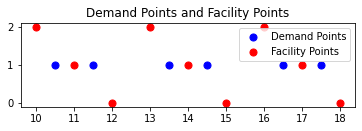

In [13]:
import matplotlib.pyplot as plt

# Create a plot
fig, ax = plt.subplots()

# Plot demand points and facility points
dem_b.plot(ax=ax, color="blue", markersize=50, label="Demand Points")
fac_b.plot(ax=ax, color="red", markersize=50, label="Facility Points")

# Set plot title and legend
ax.set_title("Demand Points and Facility Points")
ax.legend()

# Show the plot
plt.show()


In [14]:
initial_k_b = [1] * len(sample_client_b)
prob_b = KNearestPMedian.from_geodataframe(
    initial_k_b,
    dem_b,
    fac_b,
    "geometry",
    "geometry",
    "demand",
    6,
    facility_capacity_col="capacity",
    distance_metric="euclidean",
)

In [15]:
prob_b = prob_b.solve(pulp.PULP_CBC_CMD(msg=False))

In [16]:
for i in range(6):
    for j in range(9):
        if (i, j) in prob_b.cli_assgn_vars and prob_b.cli_assgn_vars[
            (i, j)
        ].value() == 1:
            print(i, j)


0 1
1 0
2 4
3 3
4 7
5 6


##### Test with spopt

In [150]:
import sys
!{sys.executable} -m venv kpmedian_test


In [1]:
!source kpmedian_test/bin/activate

In [171]:
pip install /Users/xrb/Desktop/RA-IOE/Untitled

Processing /Users/xrb/Desktop/RA-IOE/Untitled
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for spopt: filename=spopt-0.1.dev980+g5ef3bdc.d20230808-py3-none-any.whl size=239547 sha256=bb4417880f7e64f55f8217ec65e6d4a1a4b17e18e36c9bebcb1a9edbb3a70a0a
  Stored in directory: /private/var/folders/v1/b3bx117j02qghrlmbvc478780000gn/T/pip-ephem-wheel-cache-8mqjqpm2/wheels/93/eb/e5/aa211935151a30a3e08a46912bbd072b4e25cd3e834dd97e61
Successfully built spopt
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: spopt
    Found existing inst

In [3]:
from shapely.geometry import Point
import geopandas as gpd

# Sample demand points data
demand_data = {
    "DemandID": [1, 2],
    "geometry": [Point(0.5, 1), Point(1.5, 1)],
    "demand": [1, 1],
}
dem = gpd.GeoDataFrame(demand_data, crs="EPSG:4326")

# Sample facility points data
facility_data = {
    "FacilityID": [101, 102, 103],
    "geometry": [Point(1, 1), Point(0, 2), Point(2, 0)],
    "capacity": [1, 1, 1],
}
fac = gpd.GeoDataFrame(facility_data, crs="EPSG:4326")
intial_k = [1, 1]

In [17]:
from spopt.locate import KNearestPMedian

In [4]:
prob = KNearestPMedian.from_geodataframe(
    intial_k,
    dem,
    fac,
    "geometry",
    "geometry",
    "demand",
    3,
    facility_capacity_col="capacity",
    distance_metric="euclidean",
)

In [6]:
import pulp
prob = prob.solve(pulp.PULP_CBC_CMD(msg=False))

In [7]:
for i in range(2):
    for j in range(3):
        if (i, j) in prob.cli_assgn_vars and prob.cli_assgn_vars[(i, j)].value() == 1:
            print(i, j)

0 1
1 0


In [1]:
import sklearn
from sklearn.neighbors import KDTree, BallTree
print(sklearn.__version__)

1.3.0


In [3]:
kdtree_valid_metrics = KDTree.valid_metrics
metric = 'euclidean'
if metric in kdtree_valid_metrics:
    print(metric)

TypeError: argument of type 'builtin_function_or_method' is not iterable

In [5]:
basic_from_w_labels = [0, 0, 2, 0, 0, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2]
basic_from_w_labels += [1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1]
print(basic_from_w_labels)

[0, 0, 2, 0, 0, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1]


In [6]:
print(len(basic_from_w_labels))

32


In [11]:
y= basic_from_w_labels

In [7]:
y=[0, 0, 2, 0, 0, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,0, 0, 0, 2, 2, 2, 0, 0, 0, 1]